## 필요한 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

from sklearn.preprocessing import LabelEncoder

/var/folders/99/nq_0xdns2_30vrd59rccbsr00000gn/T/ipykernel_62527/3727866039.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
# tabnet 설치
# ! pip install pytorch-tabnet

In [64]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [ ]:
df_train = pd.read_csv('Desktop/LG-aimers/data/df_train.csv', index_col = 0)
df_test = pd.read_csv('Desktop/LG-aimers/data/df_test.csv', index_col = 0)

In [ ]:
# 전처리된 데이터 불러오기
df_train = pd.read_csv('Desktop/LG-aimers/data/train_final.csv', index_col = 0)
df_test = pd.read_csv('Desktop/LG-aimers/data/train_final.csv', index_col = 0)

In [5]:
df_all = pd.concat([df_train, df_test.drop('id', axis = 1)] , ignore_index = True)
df_all.shape

(64570, 29)

In [43]:
# 제출 전 정답값 비교하기 위함
# 참고용
df_55 = pd.read_csv('submission_optuna5.csv')
df_60 = pd.read_csv('submission_optuna6.csv')
df_61 = pd.read_csv('submission_optuna7.csv')
df_63 = pd.read_csv('submission_tabnet_63.csv')

In [ ]:
# seed 설정
seed = 400
torch.manual_seed(seed)
np.random.seed(seed)

# GPU 사용이 가능하면 GPU 랜덤 시드도 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [7]:
# categorical 변수 지정
label = ['customer_country', 'business_unit', 'customer_idx', 'customer_type',
         'enterprise', 'customer_job', 'inquiry_type', 'product_category', 'product_subcategory', 'product_modelname',
         'customer_position', 'response_corporate', 'expected_timeline',
         'business_area', 'business_subarea', 'lead_owner', 'category', 'idit_all']

In [47]:
def preprocessing(df_train, df_test):
    df_all = pd.concat([df_train, df_test.drop('id', axis = 1)] , ignore_index = True)

    # 전처리 
    df_all['inquiry_type'] = df_all['inquiry_type'].fillna('nan')

    # business area, subarea 모두 nan으로 채움
    df_all['business_area'] = df_all['business_area'].fillna('nan')
    df_all['business_subarea'] = df_all['business_subarea'].fillna('nan')
    
    # ver_win_rate_x, ver_win_ratio_per_bu, com_reg_ver_win_rate 모두 null값 0으로 처리
    df_all['ver_win_rate_x'] = df_all['ver_win_rate_x'].fillna(0)
    df_all['ver_win_ratio_per_bu'] = df_all['ver_win_ratio_per_bu'].fillna(0)
    df_all['com_reg_ver_win_rate'] = df_all['com_reg_ver_win_rate'].fillna(0)

    # label encoding
    for col in label:
        le = LabelEncoder()
        df_all[col] = le.fit_transform(df_all[col].values)

    # train, test 다시 분리
    df_train = df_all.iloc[: len(df_train)]
    df_test = df_all.iloc[len(df_train):]

    # target 인코딩
    df_train['is_converted'] = df_train['is_converted'].apply(lambda x: 1 if x == True else 0)

    return df_train, df_test

In [58]:
# smote
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

def smote(method, df):
    smt = SMOTE(random_state = 400)
    smoteto = SMOTETomek(tomek = TomekLinks(sampling_strategy = 'majority'), random_state = 400)
    bdsmt = BorderlineSMOTE(random_state = 400)

    if method == 'smt':
        trsx, trsy = smt.fit_resample(df.drop('is_converted', axis = 1), df['is_converted'])
        
    elif method == 'smoteto':
        trsx, trsy = smoteto.fit_resample(df.drop('is_converted', axis = 1), df['is_converted'])

    elif method == 'bdsmt':
        trsx, trsy = bdsmt.fit_resample(df.drop('is_converted', axis = 1), df['is_converted'])
    else:
        print('method error')

    return trsx, trsy
    

In [12]:
# 데이터 학습 위한 학습 데이터 전처리 
# 오버샘플링, cat_idxs/dims 지정 
def before_train(smote_method, df):
    # 오버샘플링
    # smote: smt, smote+tomek: smoteto, borderline smote: bdsmt
    trsx, trsy = smote(smote_method, df)

    # cat_idxs, cat_dims 지정 
    use_label = [col for col in df.columns if col in label]
    
    categorical_dim = {}
    for col in use_label:
        categorical_dim[col] = df_all[col].nunique()

    cat_idxs = [trsx.columns.get_loc(col) for col in use_label]
    cat_dims = [categorical_dim[f] for f in use_label]

    return trsx, trsy, cat_idxs, cat_dims
    
    
    

In [ ]:
# cv 진행하지 않을 경우 
x_train, x_val, y_train, y_val = train_test_split(
    trsx,
    trsy,
    stratify = trsy,
    test_size = 0.2,
    shuffle = True,
    random_state = 400)

# tabnet에는 ndarray로 입력
x_train = x_train.values 
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values 

# cv 진행할 경우 
trsx = trsx.values
trsy = trsy.values 

In [28]:
# 결과 시각화 함수 
def result_vis(model, df):
    # f1_score, loss 
    fig, ax = plt.subplots(1,2, figsize = (16,8))

    ax[0].plot(model.history['val_0_F1_score'])
    ax[0].set_title('f1_score')
    ax[1].plot(model.history['loss'])
    ax[1].set_title('loss')

    # feature importances
    feature_importances = model.feature_importances_
    num_features = len(feature_importances)
    plt.figure(figsize = (10,6))
    plt.barh(range(num_features), feature_importances, align = 'center')
    plt.yticks(np.arange(num_features), df.drop('is_converted', axis = 1).columns)
    plt.xlabel('feature importance')
    plt.title('tabnet feature importances')
    plt.show()

In [23]:
# f1 score metric 지정
class F1_Score(Metric):
    def __init__(self):
        self._name = 'F1_score'
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis = 1)
        score = f1_score(y_true, y_pred, average = 'macro')
        return score

In [52]:
# 성능 높았던 결과와 True 수, 얼마나 똑같은지 비교하기 위함
def compare(data):
    sum_1 = np.sum(data)
    print(f'실제 True수: {sum_1}')
    ex = np.where((data+df_55['is_converted'])==2, 1,0) 
    print(f'55%: {np.sum(ex)}')
    ex = np.where((data+df_60['is_converted'])==2, 1,0) 
    print(f'60%: {np.sum(ex)}')
    ex = np.where((data+df_61['is_converted'])==2, 1,0) 
    print(f'61%: {np.sum(ex)}')
    ex = np.where((data+df_63['is_converted'])==2, 1,0) 
    print(f'63%: {np.sum(ex)}')
    print('-'*20)
    print('55%: ', df_55[df_55['is_converted'] == data].shape)
    print('60%: ', df_60[df_60['is_converted'] == data].shape)
    print('61%: ', df_61[df_61['is_converted'] == data].shape)
    print('63%: ', df_63[df_63['is_converted'] == data].shape)

## 결과 비교 

### 최종 f1: 0.635
- 불필요한 변수 제거(lead_desc_length, product, timeline_count, idx_count)
    - length는 log 변환했으므로 삭제
    - product는 세부 내용이 매우 다양하고 모델 돌리면서 주로 중요도가 낮게 나와 제거 => category만 사용
    - timeline_count도 주로 중요도가 낮아 제거
    - idx_count는 중복값 제거하고 enterprise 종류 변수가 생성되어 있으니 필요 없을 것 같다는 판단 

In [16]:
train_remove = df_train.drop(['lead_desc_length', 'product_category', 'product_subcategory', 'product_modelname', 'timeline_count', 'idx_count'],
                            axis = 1)
test_remove = df_test.drop(['lead_desc_length', 'product_category', 'product_subcategory', 'product_modelname', 'timeline_count', 'idx_count'],
                            axis = 1)
train_remove.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,inquiry_type,...,is_converted,category,product_count,idit_all,bant_submit_count,com_reg_count,lead_log,lead_count,enterprise_count,enterprise_weight
0,1.0,56,0,0.066667,26225,4,0,0.0,22,5,...,1,0,1,0,0,1,4.127134,1,0,0.0
1,1.0,56,0,0.066667,18828,4,0,12.0,16,5,...,1,0,1,0,0,1,4.564348,1,1,0.0
2,1.0,31,0,0.088889,1422,4,0,144.0,8,4,...,1,0,1,0,0,1,4.025352,1,1,0.0
3,1.0,31,0,0.088889,3962,4,0,0.0,9,5,...,1,0,1,0,0,1,3.784190,1,0,0.0
4,1.0,31,0,0.088889,13863,9,0,0.0,5,5,...,1,0,1,0,0,1,4.574711,1,0,0.0


In [16]:
train_remove = df_train.drop(['lead_desc_length', 'product_category', 'product_subcategory', 'product_modelname', 'timeline_count', 'idx_count'],
                            axis = 1)
test_remove = df_test.drop(['lead_desc_length', 'product_category', 'product_subcategory', 'product_modelname', 'timeline_count', 'idx_count'],
                            axis = 1)
train_remove.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,inquiry_type,...,is_converted,category,product_count,idit_all,bant_submit_count,com_reg_count,lead_log,lead_count,enterprise_count,enterprise_weight
0,1.0,56,0,0.066667,26225,4,0,0.0,22,5,...,1,0,1,0,0,1,4.127134,1,0,0.0
1,1.0,56,0,0.066667,18828,4,0,12.0,16,5,...,1,0,1,0,0,1,4.564348,1,1,0.0
2,1.0,31,0,0.088889,1422,4,0,144.0,8,4,...,1,0,1,0,0,1,4.025352,1,1,0.0
3,1.0,31,0,0.088889,3962,4,0,0.0,9,5,...,1,0,1,0,0,1,3.784190,1,0,0.0
4,1.0,31,0,0.088889,13863,9,0,0.0,5,5,...,1,0,1,0,0,1,4.574711,1,0,0.0


In [16]:
train_remove = df_train.drop(['lead_desc_length', 'product_category', 'product_subcategory', 'product_modelname', 'timeline_count', 'idx_count'],
                            axis = 1)
test_remove = df_test.drop(['lead_desc_length', 'product_category', 'product_subcategory', 'product_modelname', 'timeline_count', 'idx_count'],
                            axis = 1)
train_remove.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,inquiry_type,...,is_converted,category,product_count,idit_all,bant_submit_count,com_reg_count,lead_log,lead_count,enterprise_count,enterprise_weight
0,1.0,56,0,0.066667,26225,4,0,0.0,22,5,...,1,0,1,0,0,1,4.127134,1,0,0.0
1,1.0,56,0,0.066667,18828,4,0,12.0,16,5,...,1,0,1,0,0,1,4.564348,1,1,0.0
2,1.0,31,0,0.088889,1422,4,0,144.0,8,4,...,1,0,1,0,0,1,4.025352,1,1,0.0
3,1.0,31,0,0.088889,3962,4,0,0.0,9,5,...,1,0,1,0,0,1,3.784190,1,0,0.0
4,1.0,31,0,0.088889,13863,9,0,0.0,5,5,...,1,0,1,0,0,1,4.574711,1,0,0.0


In [23]:
final_params = dict(n_d = 56, n_a = 56, n_steps = 1, gamma = 1.0,
                    lambda_sparse =  1.9647313403319854e-06, optimizer_fn = torch.optim.Adam,
                    cat_idxs = cat_idxs, cat_dims = cat_dims,
                    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
                    n_independent = 1, cat_emb_dim = 9,
                    mask_type = 'sparsemax', n_shared = 3,
                    scheduler_params = dict(mode = 'min',
                                            patience = 3,
                                            min_lr = 1e-5,
                                            factor = 0.5),
                    scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau,
                    verbose = 1)
epochs = 80
skf = StratifiedKFold(n_splits = 5, random_state = 400, shuffle = True)
cv_score_array = []

for train_index, test_index in skf.split(trsx, trsy):
    x_train, x_valid = trsx[train_index], trsx[test_index]
    y_train, y_valid = trsy[train_index], trsy[test_index]
    clf = TabNetClassifier(**final_params)
    clf.fit(X_train = x_train, y_train = y_train,
            eval_set = [(x_valid, y_valid)],
            patience = 8, max_epochs = epochs,
            virtual_batch_size = 256, batch_size = 2048,
            weights = 1,
            num_workers = 1,
            eval_metric=['F1_score'])

    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)

    cv_score_array.append(f1)

print(np.mean(cv_score_array))

epoch 0  | loss: 0.27804 | val_0_F1_score: 0.92223 |  0:00:15s
epoch 1  | loss: 0.1041  | val_0_F1_score: 0.94921 |  0:00:31s
epoch 2  | loss: 0.06906 | val_0_F1_score: 0.96631 |  0:00:47s
epoch 3  | loss: 0.04625 | val_0_F1_score: 0.97348 |  0:01:03s
epoch 4  | loss: 0.02981 | val_0_F1_score: 0.9777  |  0:01:19s
epoch 5  | loss: 0.02037 | val_0_F1_score: 0.97931 |  0:01:36s
epoch 6  | loss: 0.01414 | val_0_F1_score: 0.98088 |  0:01:51s
epoch 7  | loss: 0.01301 | val_0_F1_score: 0.98304 |  0:02:08s
epoch 8  | loss: 0.01105 | val_0_F1_score: 0.9825  |  0:02:24s
epoch 9  | loss: 0.00948 | val_0_F1_score: 0.98289 |  0:02:40s
epoch 10 | loss: 0.00746 | val_0_F1_score: 0.98329 |  0:02:56s
epoch 11 | loss: 0.00772 | val_0_F1_score: 0.98201 |  0:03:12s
epoch 12 | loss: 0.00575 | val_0_F1_score: 0.98309 |  0:03:28s
epoch 13 | loss: 0.00642 | val_0_F1_score: 0.98309 |  0:03:44s
epoch 14 | loss: 0.0059  | val_0_F1_score: 0.98255 |  0:04:00s
epoch 15 | loss: 0.00547 | val_0_F1_score: 0.98333 |  0

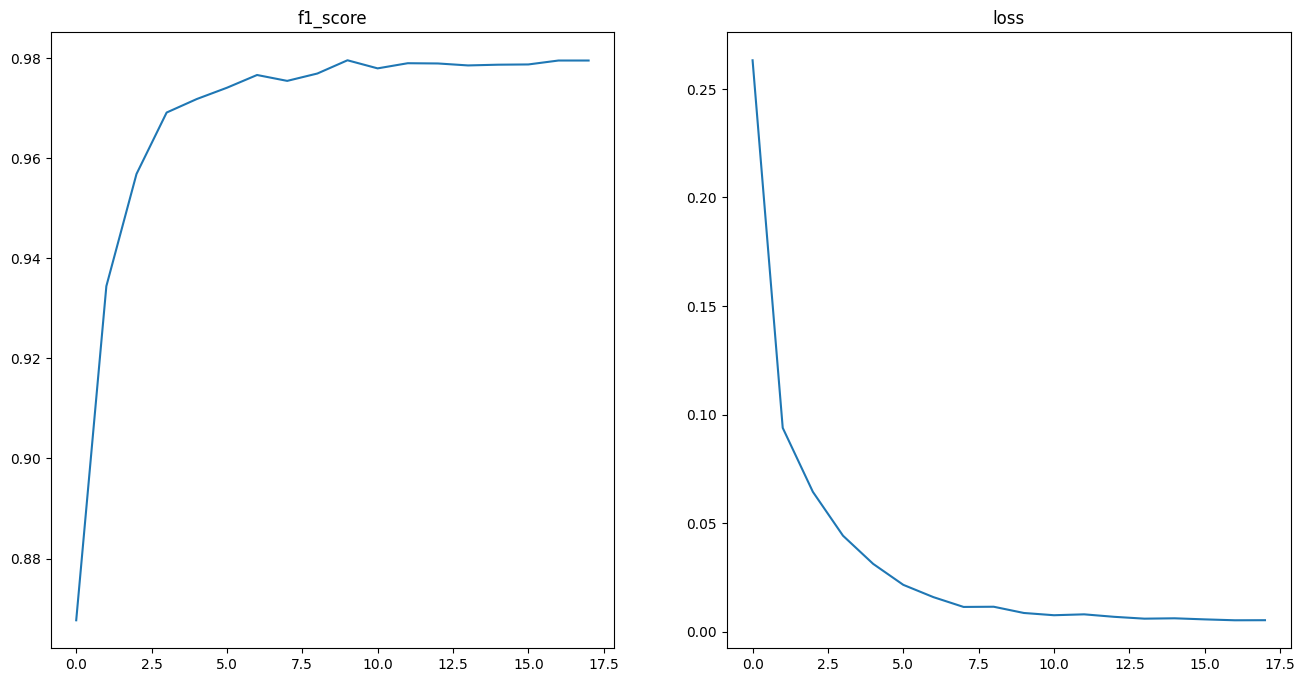

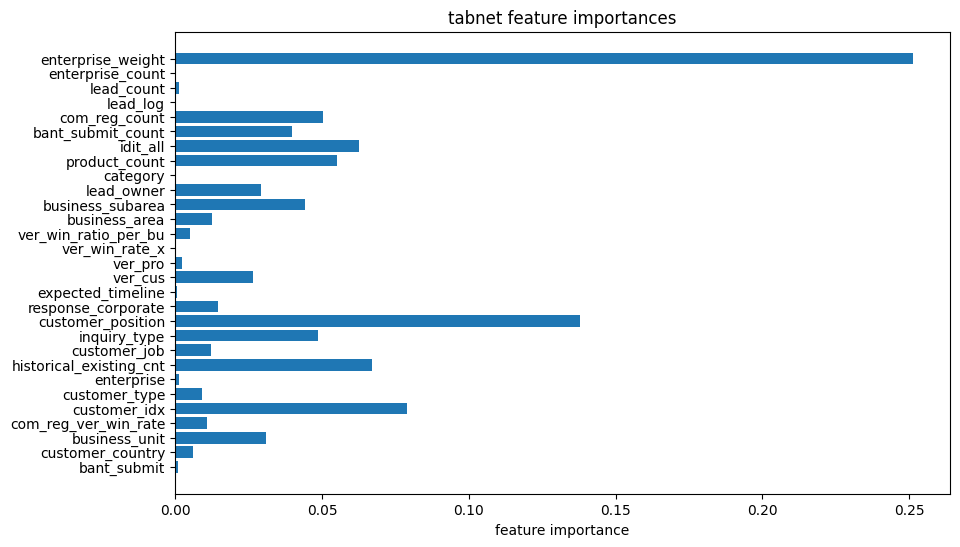

In [25]:
result_vis(clf, train_remove)

In [28]:
# 최종 예측 
x_test = test_remove.drop('is_converted', axis = 1)
x_test = x_test.values
test_pred = clf.predict(x_test)
print(f'True수: {sum(test_pred)}')
print('-'*20)
# 55%가 955개
# 60%가 1422개
# 61%가 1596개
print('55%: ', df_55[df_55['is_converted'] == test_pred].shape)
print('60%: ', df_60[df_60['is_converted'] == test_pred].shape)
print('61%: ', df_61[df_61['is_converted'] == test_pred].shape)
print('63%: ', df_63[df_63['is_converted'] == test_pred].shape)

True수: 1453
--------------------
55%:  (4409, 30)
60%:  (4376, 30)
61%:  (4438, 30)
63%:  (4613, 30)


#### 위 결과에서 중요도 낮은 변수 제거하고 재학습


In [33]:
train_remove2 = train_remove.drop(['enterprise_count', 'lead_count', 'lead_log', 'category', 'ver_win_rate_x', 'expected_timeline', 'enterprise', 'bant_submit', 'ver_pro'],
                                  axis = 1)
test_remove2 = test_remove.drop(['enterprise_count', 'lead_count', 'lead_log', 'category', 'ver_win_rate_x', 'expected_timeline', 'enterprise', 'bant_submit', 'ver_pro'],
                                  axis = 1)
# 이후 샘플링 과정은 동일하므로 제외

In [37]:
final_params = dict(n_d = 56, n_a = 56, n_steps = 1, gamma = 1.0,
                    lambda_sparse =  1.9647313403319854e-06, optimizer_fn = torch.optim.Adam,
                    cat_idxs = cat_idxs, cat_dims = cat_dims,
                    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
                    n_independent = 1, cat_emb_dim = 9,
                    mask_type = 'sparsemax', n_shared = 3,
                    scheduler_params = dict(mode = 'min',
                                            patience = 3,
                                            min_lr = 1e-5,
                                            factor = 0.5),
                    scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau,
                    verbose = 1)
epochs = 80
skf = StratifiedKFold(n_splits = 5, random_state = 400, shuffle = True)
cv_score_array = []

for train_index, test_index in skf.split(trsx, trsy):
    x_train, x_valid = trsx[train_index], trsx[test_index]
    y_train, y_valid = trsy[train_index], trsy[test_index]
    clf = TabNetClassifier(**final_params)
    clf.fit(X_train = x_train, y_train = y_train,
            eval_set = [(x_valid, y_valid)],
            patience = 8, max_epochs = epochs,
            virtual_batch_size = 256, batch_size = 2048,
            weights = 1,
            num_workers = 1,
            eval_metric=['F1_score'])

    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)

    cv_score_array.append(f1)

print(np.mean(cv_score_array))

epoch 0  | loss: 0.25035 | val_0_F1_score: 0.87281 |  0:00:16s
epoch 1  | loss: 0.09664 | val_0_F1_score: 0.93742 |  0:00:32s
epoch 2  | loss: 0.06626 | val_0_F1_score: 0.94757 |  0:00:48s
epoch 3  | loss: 0.04414 | val_0_F1_score: 0.95433 |  0:01:04s
epoch 4  | loss: 0.0314  | val_0_F1_score: 0.96587 |  0:01:19s
epoch 5  | loss: 0.02193 | val_0_F1_score: 0.97235 |  0:01:35s
epoch 6  | loss: 0.01591 | val_0_F1_score: 0.97294 |  0:01:51s
epoch 7  | loss: 0.01295 | val_0_F1_score: 0.97623 |  0:02:07s
epoch 8  | loss: 0.01071 | val_0_F1_score: 0.97804 |  0:02:22s
epoch 9  | loss: 0.0091  | val_0_F1_score: 0.9774  |  0:02:38s
epoch 10 | loss: 0.00663 | val_0_F1_score: 0.97873 |  0:02:54s
epoch 11 | loss: 0.00653 | val_0_F1_score: 0.97961 |  0:03:10s
epoch 12 | loss: 0.00516 | val_0_F1_score: 0.97878 |  0:03:26s
epoch 13 | loss: 0.00529 | val_0_F1_score: 0.97922 |  0:03:42s
epoch 14 | loss: 0.00486 | val_0_F1_score: 0.97922 |  0:03:58s
epoch 15 | loss: 0.00434 | val_0_F1_score: 0.98015 |  0

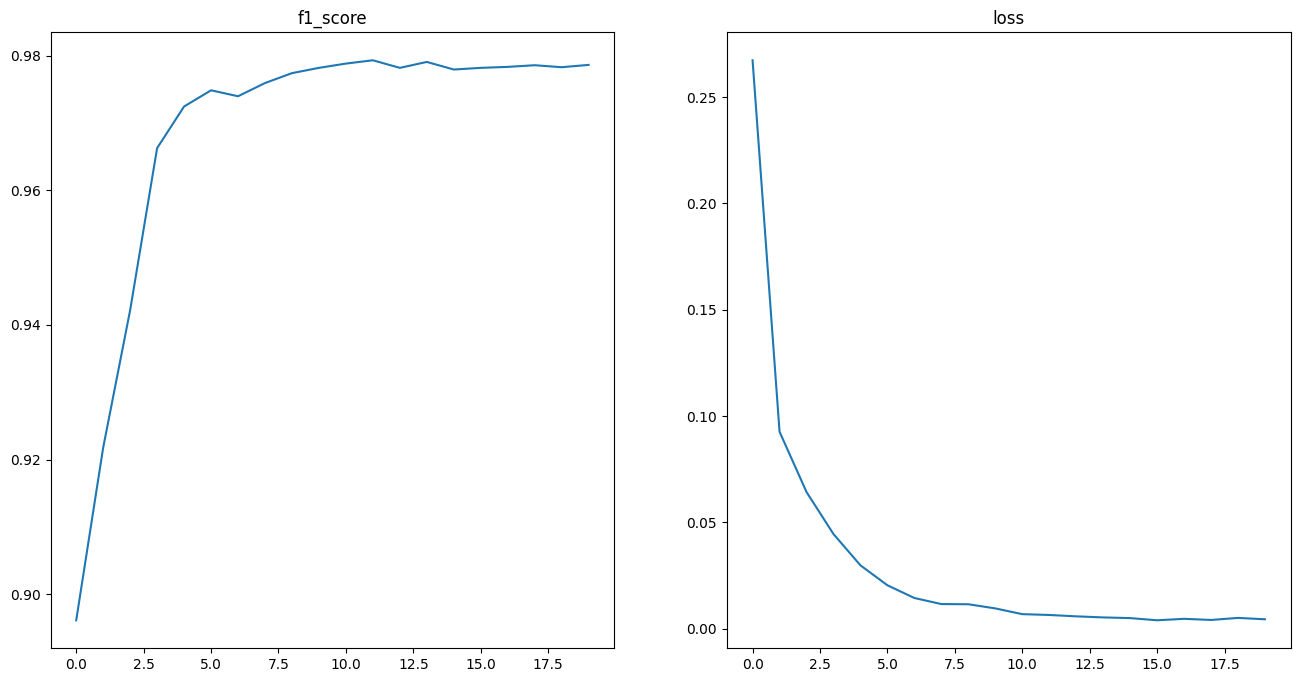

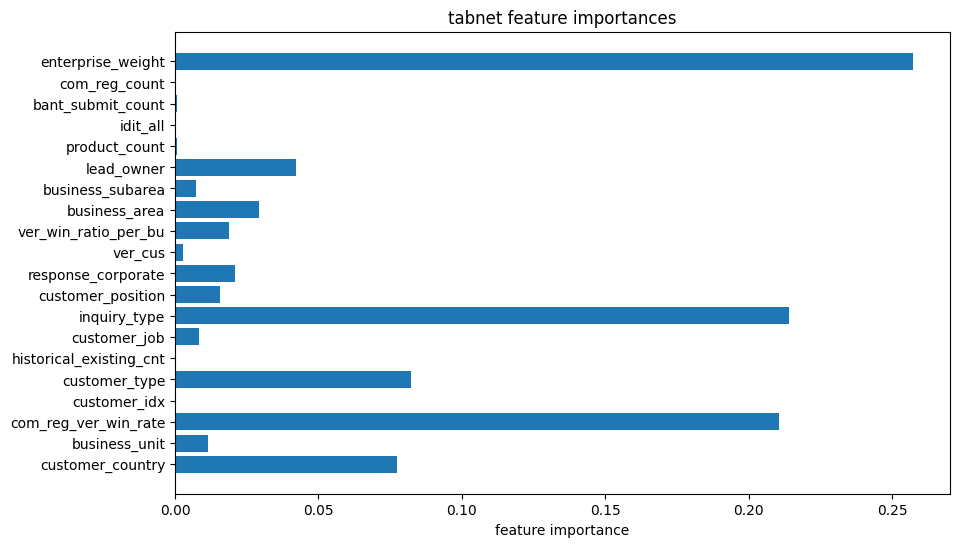

In [38]:
result_vis(clf, train_remove2)

In [39]:
# 최종 예측 
x_test = test_remove2.drop('is_converted', axis = 1)
x_test = x_test.values
test_pred2 = clf.predict(x_test)
print(f'True수: {sum(test_pred2)}')
print('-'*20)
# 55%가 955개
# 60%가 1422개
# 61%가 1596개
print('55%: ', df_55[df_55['is_converted'] == test_pred2].shape)
print('60%: ', df_60[df_60['is_converted'] == test_pred2].shape)
print('61%: ', df_61[df_61['is_converted'] == test_pred2].shape)
print('63%: ', df_63[df_63['is_converted'] == test_pred2].shape)

True수: 1419
--------------------
55%:  (4383, 30)
60%:  (4424, 30)
61%:  (4554, 30)
63%:  (4575, 30)


In [69]:
compare(test_pred)

실제 True수: 1453
55%: 773
60%: 990
61%: 1108
63%: 1066
--------------------
55%:  (4409, 30)
60%:  (4376, 30)
61%:  (4438, 30)
63%:  (4613, 30)


In [70]:
compare(test_pred2)

실제 True수: 1419
55%: 743
60%: 997
61%: 1149
63%: 1030
--------------------
55%:  (4383, 30)
60%:  (4424, 30)
61%:  (4554, 30)
63%:  (4575, 30)


In [61]:
# 둘 중 하나라도 1이면
all_pred = np.where((test_pred+test_pred2)>=1,1,0)
print(f'True수: {np.sum(all_pred)}')
print('55%: ', df_55[df_55['is_converted'] == all_pred].shape)
print('60%: ', df_60[df_60['is_converted'] == all_pred].shape)
print('61%: ', df_61[df_61['is_converted'] == all_pred].shape)
print('63%: ', df_63[df_63['is_converted'] == all_pred].shape)

True수: 1835
55%:  (4141, 30)
60%:  (4344, 30)
61%:  (4526, 30)
63%:  (4457, 30)


In [63]:
compare(all_pred)

실제 True수: 1835
55%: 830
60%: 1165
61%: 1343
63%: 1179
--------------------
55%:  (4141, 30)
60%:  (4344, 30)
61%:  (4526, 30)
63%:  (4457, 30)


In [65]:
df_sub = pd.read_csv('submission (1).csv')
df_sub['is_converted'] = all_pred
df_sub.to_csv('submission_tabnet_all_pred.csv', index = False)

### 최종 f1: 0.63
- smote+tomek 적용
- 변수 모두 넣고 진행


In [27]:
# train_pre.csv 사용 
df_train = pd.read_csv('train_pre.csv')
df_test = pd.read_csv('submission_pre.csv')

In [16]:
df_train.shape

(59299, 29)

In [36]:
df_all = pd.concat([df_train, df_test.drop('id', axis = 1)] , ignore_index = True)

In [13]:
trsx, trsy, cat_idxs, cat_dims = before_train('smoteto', df_train)

In [21]:
# cv 진행하지 않을 경우 
x_train, x_val, y_train, y_val = train_test_split(
    trsx,
    trsy,
    stratify = trsy,
    test_size = 0.2,
    shuffle = True,
    random_state = 400)

# tabnet에는 ndarray로 입력
x_train = x_train.values 
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values 

# cv 진행할 경우 
trsx = trsx.values
trsy = trsy.values 

In [24]:
# cv 진행 x 
# 변수 모두 넣고 튜닝한 모델
final_params = dict(n_d = 64, n_a = 64, n_steps = 1, gamma = 1.8,
                    lambda_sparse =  0.000893179523178875, optimizer_fn = torch.optim.Adam,
                    cat_idxs = cat_idxs, cat_dims = cat_dims,
                    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
                    n_independent = 3, cat_emb_dim = 10,
                    mask_type = 'entmax', n_shared = 1,
                    scheduler_params = dict(mode = 'min',
                                            patience = 4,
                                            min_lr = 1e-5,
                                            factor = 0.5),
                    scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau,
                    verbose = 0)
epochs = 89

clf = TabNetClassifier(**final_params)
clf.fit(X_train = x_train, y_train = y_train,
        eval_set = [(x_val, y_val)],
        patience = 10, max_epochs = epochs,
        virtual_batch_size = 128, batch_size = 1024,
        weights = 1,
        num_workers = 0,
        eval_metric=['F1_score'])


Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_F1_score = 0.98413


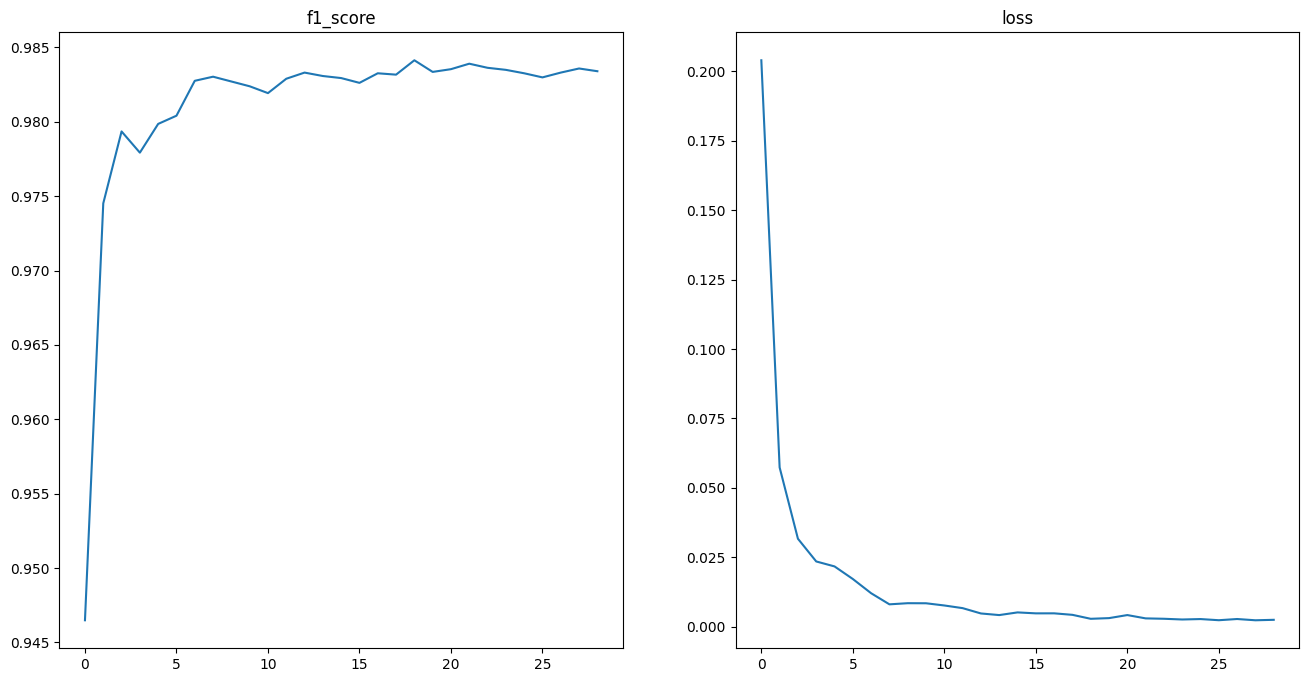

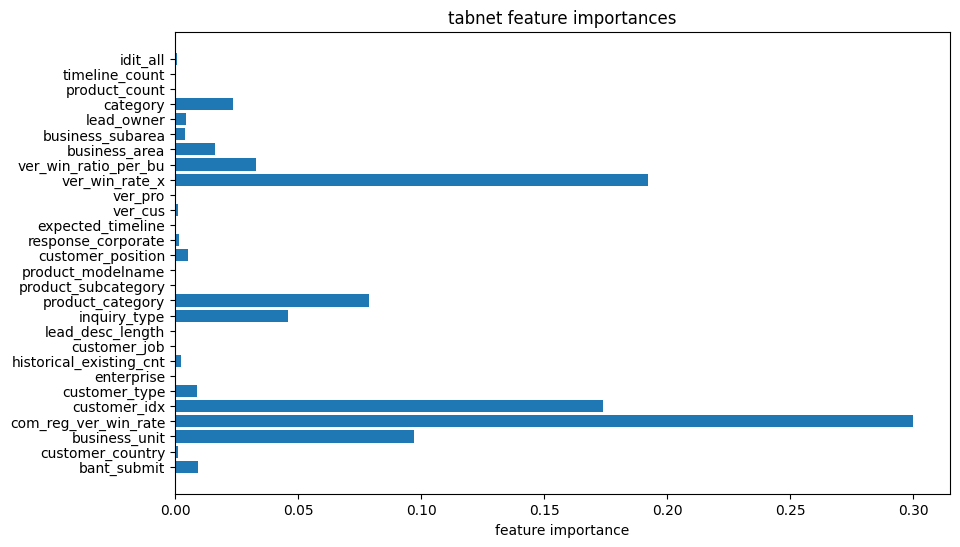

In [29]:
# 결과 시각화 
result_vis(clf, df_train)

In [44]:
# 최종 예측 
x_test = df_test.drop('is_converted', axis = 1)
x_test = x_test.values
test_pred = clf.predict(x_test)
print(f'True수: {sum(test_pred)}')
print('-'*20)
# 55%가 955개
# 60%가 1422개
# 61%가 1596개
print('55%: ', df_55[df_55['is_converted'] == test_pred].shape)
print('60%: ', df_60[df_60['is_converted'] == test_pred].shape)
print('61%: ', df_61[df_61['is_converted'] == test_pred].shape)

True수: 1337
--------------------
55%:  (4573, 30)
60%:  (4408, 30)
61%:  (4440, 30)


In [ ]:
# 제출
df_sub = pd.read_csv('Desktop/lg_aimers/submission (1).csv')
df_sub['is_converted'] = test_pred
df_sub.to_csv('submission_tabnet_63.csv', index = False)

In [45]:
# 모델 저장
saving_path_name = "./tabnet_model_63"
saved_filepath = clf.save_model(saving_path_name)


Successfully saved model at ./tabnet_model_63.zip


### 최종 f1: 0.61
- 잠시 보류(데이터 불일치)
- 모델 저장되어 있음(tabnet_model_61.zip)


In [49]:
# train_fe 사용 
df_train = pd.read_csv('train_fe.csv')
df_test = pd.read_csv('submission_fe.csv')
df_train.head()


,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,...,category,product_count,timeline_count,idit_all,bant_submit_count,com_reg_count,idx_count,lead_log,lead_count,enterprise_count
0,1.0,philippines,AS,0.066667,32160,End Customer,Enterprise,0.0,purchasing,62,...,HVAC/ESS,1,0,0,1,1,1,4.127134,1,0
1,1.0,philippines,AS,0.066667,23122,End Customer,Enterprise,12.0,media and communication,96,...,HVAC/ESS,1,0,0,1,1,1,4.564348,1,1
2,1.0,india,AS,0.088889,1755,End Customer,Enterprise,144.0,engineering,56,...,HVAC/ESS,1,0,0,1,1,1,4.025352,1,1
3,1.0,india,AS,0.088889,4919,End Customer,Enterprise,0.0,entrepreneurship,44,...,HVAC/ESS,1,0,0,1,1,0,3.784190,1,0
4,1.0,india,AS,0.088889,17126,"Specifier, Influencer",Enterprise,0.0,consulting,97,...,HVAC/ESS,1,0,0,1,1,0,4.574711,1,0


In [51]:
df_train, df_test = preprocessing(df_train, df_test)
df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,...,category,product_count,timeline_count,idit_all,bant_submit_count,com_reg_count,idx_count,lead_log,lead_count,enterprise_count
0,1.0,56,0,0.066667,26225,4,0,0.0,22,62,...,0,1,0,0,1,1,1,4.127134,1,0
1,1.0,56,0,0.066667,18828,4,0,12.0,16,96,...,0,1,0,0,1,1,1,4.564348,1,1
2,1.0,30,0,0.088889,1422,4,0,144.0,8,56,...,0,1,0,0,1,1,1,4.025352,1,1
3,1.0,30,0,0.088889,3962,4,0,0.0,9,44,...,0,1,0,0,1,1,0,3.784190,1,0
4,1.0,30,0,0.088889,13863,9,0,0.0,5,97,...,0,1,0,0,1,1,0,4.574711,1,0


In [52]:
# 'ver_win_ratio_per_bu', 'ver_cus', 'customer_position', 'product_category', 'bant_submit'
# 'customer_country', 'lead_desc_length', 'expected_timeline', 'bant_submit_count', 'lead_count', 'timeline_count'
# 변수 제거하고 진행 
df_train.drop(['ver_win_ratio_per_bu', 'ver_cus', 'customer_position', 'product_category', 'bant_submit',
               'customer_country', 'lead_desc_length', 'expected_timeline', 'bant_submit_count', 'lead_count', 'timeline_count'],
              axis = 1, inplace = True)
df_test.drop(['ver_win_ratio_per_bu', 'ver_cus', 'customer_position', 'product_category', 'bant_submit',
               'customer_country', 'lead_desc_length', 'expected_timeline', 'bant_submit_count', 'lead_count', 'timeline_count'],
              axis = 1, inplace = True)

In [59]:
trsx, trsy, cat_idxs, cat_dims = before_train('bdsmt', df_train)

In [60]:
trsx.shape

(108898, 23)

In [ ]:
# cv 진행하지 않을 경우 
x_train, x_val, y_train, y_val = train_test_split(
    trsx,
    trsy,
    stratify = trsy,
    test_size = 0.2,
    shuffle = True,
    random_state = 400)

# tabnet에는 ndarray로 입력
x_train = x_train.values 
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values 

# cv 진행할 경우 
trsx = trsx.values
trsy = trsy.values 

In [ ]:
final_params = dict(n_d = 48, n_a = 48, n_steps = 3, gamma = 2.0,
                    lambda_sparse =  1.9155555506953783e-05, optimizer_fn = torch.optim.Adam,
                    cat_idxs = cat_idxs, cat_dims = cat_dims,
                    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
                    n_independent = 5, cat_emb_dim = 6,
                    mask_type = 'entmax', n_shared = 3,
                    scheduler_params = dict(mode = 'min',
                                            patience = 6,
                                            min_lr = 1e-5,
                                            factor = 0.5),
                    scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau,
                    verbose = 0)
epochs = 59
skf = StratifiedKFold(n_splits = 5, random_state = 400, shuffle = True)
cv_score_array = []

for train_index, test_index in skf.split(trsx, trsy):
    x_train, x_valid = trsx[train_index], trsx[test_index]
    y_train, y_valid = trsy[train_index], trsy[test_index]
    clf = TabNetClassifier(**final_params)
    clf.fit(X_train = x_train, y_train = y_train,
            eval_set = [(x_valid, y_valid)],
            patience = 9, max_epochs = epochs,
            virtual_batch_size = 256, batch_size = 1024,
            weights = 1,
            num_workers = 0,
            eval_metric=['F1_score'])

    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)

    cv_score_array.append(f1)

print(np.mean(cv_score_array))


Early stopping occurred at epoch 35 with best_epoch = 26 and best_val_0_F1_score = 0.97198

Early stopping occurred at epoch 29 with best_epoch = 20 and best_val_0_F1_score = 0.969

Early stopping occurred at epoch 37 with best_epoch = 28 and best_val_0_F1_score = 0.97444

Early stopping occurred at epoch 37 with best_epoch = 28 and best_val_0_F1_score = 0.97182

Early stopping occurred at epoch 27 with best_epoch = 18 and best_val_0_F1_score = 0.97193
0.9718646636805814


Text(0.5, 1.0, 'loss')

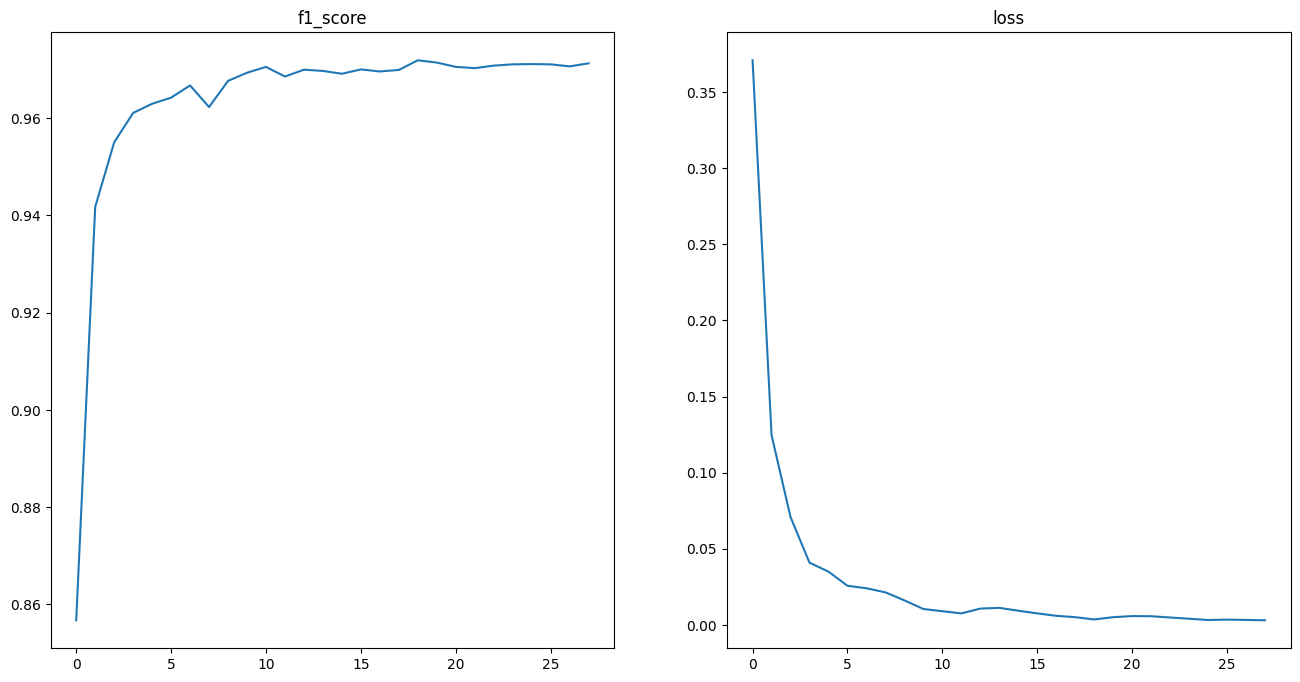

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (16,8))

ax[0].plot(clf.history['val_0_F1_score'])
ax[0].set_title('f1_score')
ax[1].plot(clf.history['loss'])
ax[1].set_title('loss')

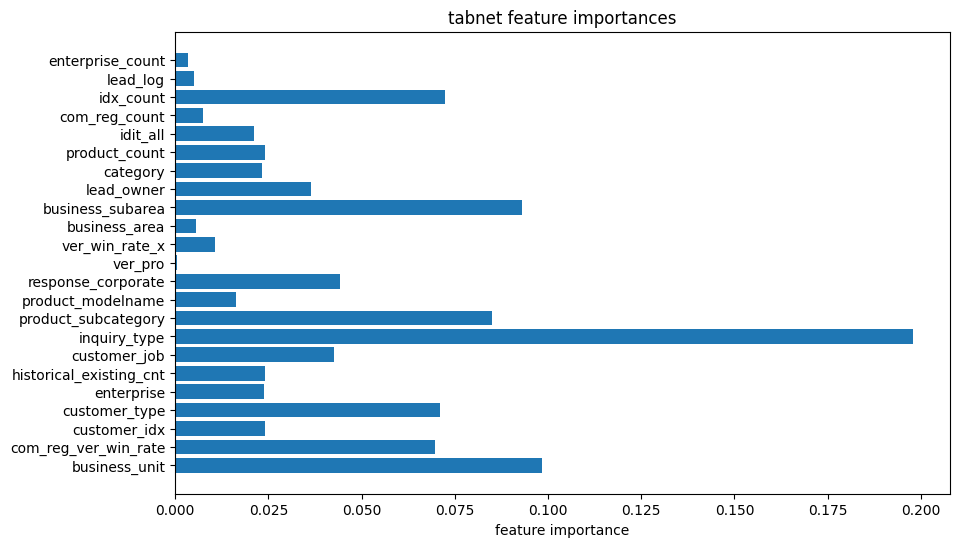

In [ ]:
feature_importances = clf.feature_importances_
num_features = len(feature_importances)
plt.figure(figsize = (10,6))
plt.barh(range(num_features), feature_importances, align = 'center')
plt.yticks(np.arange(num_features), df_train.drop('is_converted', axis = 1).columns)
plt.xlabel('feature importance')
plt.title('tabnet feature importances')
plt.show()


In [ ]:
x_test = df_test.drop('is_converted', axis = 1)
x_test_np = x_test.values
test_pred = clf.predict(x_test_np)
sum(test_pred)

1596

In [ ]:
df_55[df_55['is_converted'] == test_pred].shape

(4300, 30)

In [ ]:
df_60[df_60['is_converted'] == test_pred].shape

(4655, 30)

In [ ]:
# 0.61
df_sub = pd.read_csv('/content/drive/MyDrive/lgaimers/submission.csv')
df_sub['is_converted'] = test_pred
df_sub.to_csv('submission_optuna7.csv', index = False)

In [ ]:
# 모델 저장
# save tabnet model
saving_path_name = "./tabnet_model_61"
saved_filepath = clf.save_model(saving_path_name)

# 후에 모델 불러오는 코드
# loaded_clf = TabNetClassifier()
# loaded_clf.load_model(saved_filepath)

Successfully saved model at ./tabnet_model_61.zip
